# Logistic Regression to predict the selling price of a used car

The dataset contains historical car auction sales prices, scraped from the outside internet sources (Kaggle). This dataset has been collected in 2015 and contain 558838 records.

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('GRPPRJUSEDCARS').getOrCreate()

Due to Limitations of the filesize to upload on the databricks community edition, we had to split it into four file. Read all four files and merge them for a dataframe

In [0]:
# File location and type
file_location = "/FileStore/tables/car_prices__1.csv"
file_type = "csv"

# CSV options
infer_schema = "true" #false
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df1 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

#display(df1)
df1.head()

Out[88]: Row(year=2015, make='Kia', model='Sorento', trim='LX', body='SUV', transmission='automatic', vin='5xyktca69fg566472', state='ca', condition=5.0, odometer=16639, color='white', interior='black', seller='kia motors america, inc', mmr=20500, sellingprice=21500, saledate='Tue Dec 16 2014 12:30:00 GMT-0800 (PST)')

In [0]:
# File location and type
file_location = "/FileStore/tables/car_prices_2.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df2 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("sep", delimiter) \
  .load(file_location)

#display(df2)
df2.head()

Out[89]: Row(_c0='2007', _c1='Toyota', _c2='Prius', _c3='Base', _c4='Hatchback', _c5='automatic', _c6='jtdkb20u273235378', _c7='nv', _c8='4.3', _c9='70211', _c10='gray', _c11='gray', _c12='michael hohl motor company', _c13='6850', _c14='10100', _c15='Fri Jan 16 2015 03:45:00 GMT-0800 (PST)')

In [0]:
# File location and type
file_location = "/FileStore/tables/car_prices_3.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df3 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("sep", delimiter) \
  .load(file_location)

#display(df3)
df3.head()

Out[90]: Row(_c0='2009', _c1='Chevrolet', _c2='Malibu', _c3='LS', _c4='Sedan', _c5='automatic', _c6='1g1zg57b39f134866', _c7='nc', _c8='2', _c9='146605', _c10='black', _c11='tan', _c12='barnett finance company', _c13='4100', _c14='3700', _c15='Tue Feb 10 2015 01:15:00 GMT-0800 (PST)')

In [0]:
# File location and type
file_location = "/FileStore/tables/car_prices_4.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df4 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("sep", delimiter) \
  .load(file_location)

#display(df4)
df4.head()

Out[91]: Row(_c0='2005', _c1='GMC', _c2='Canyon', _c3='Z85 SLE', _c4='Crew Cab', _c5='automatic', _c6='1gtds136058190201', _c7='ca', _c8='2.5', _c9='190330', _c10='white', _c11='gray', _c12='ecars', _c13='3550', _c14='5000', _c15='Tue May 19 2015 05:30:00 GMT-0700 (PDT)')

In [0]:
#Merging all four files
df=df1.union(df2).union(df3).union(df4)

##### Data pre-processing

In [0]:
#removed vin, seller & saledate as they are not relevant in determining the selling price
#created new column as sale year to calcualte the age of the vehicle.
#also converting into appropriate data types
dfreal = df.selectExpr("cast(year as int) year",
                       "cast(make as string) make",
                       "cast(model as string) model",
                       "cast(trim as string) trim",
                       "cast(body as string) body",
                       "cast(transmission as string) transmission",
                       "cast(state as string) state",
                       "cast(condition as double) condition",
                       "cast(odometer as int) odometer",
                       "cast(color as string) color",
                       "cast(interior as string) interior",
                       "cast(mmr as int) mmr",
                       "cast(sellingprice as int) sellingprice",
                       "cast(substring(saledate,12,4) as int) saleyear")

In [0]:
#Calculating the age of the vehicle
dfreal = dfreal.withColumn("vage",dfreal.saleyear-dfreal.year)

In [0]:
#drop year and saleyear, now that we have age of the vehicle
dfreal = dfreal.drop("year","saleyear")

In [0]:
dfreal.printSchema()

root
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- vage: integer (nullable = true)



In [0]:
#dimensions of data
dfreal.count(),len(dfreal.columns)


Out[97]: (558837, 13)

In [0]:
dfreal.describe().toPandas().transpose()
#dfreal.describe('sellingprice').toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
make,548536,None,None,Acura,vw
model,548438,798.4558724957176,804.7779516812842,1,yukon
trim,548186,351.9466127401417,826.0899047351874,!,zx3
body,545642,None,None,Navitgation,xtracab
transmission,493484,None,None,Sedan,sedan
state,558837,None,None,3vwd17aj0fm227318,wi
condition,547017,3.424512218084565,0.9494387859565863,1.0,5.0
odometer,558743,68320.01665345248,53398.54424434256,1,999999
color,558088,9048.115384615385,6426.680159005413,11034,â€”


In [0]:
# import sql function pyspark
import pyspark.sql.functions as f

# null values in each column
data_agg = dfreal.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in dfreal.columns])
data_agg.show()

+-----+-----+-----+-----+------------+-----+---------+--------+-----+--------+---+------------+----+
| make|model| trim| body|transmission|state|condition|odometer|color|interior|mmr|sellingprice|vage|
+-----+-----+-----+-----+------------+-----+---------+--------+-----+--------+---+------------+----+
|10301|10399|10651|13195|       65353|    0|    11820|      94|  749|     749| 26|           0|  26|
+-----+-----+-----+-----+------------+-----+---------+--------+-----+--------+---+------------+----+



In [0]:
# value counts of Make column
dfreal.groupBy('make').count().show()

+-----------+-----+
|       make|count|
+-----------+-----+
| Volkswagen|12581|
| Oldsmobile|  364|
|   Infiniti|15305|
|      buick|   14|
| land rover|  129|
|      Lexus|11861|
|     Jaguar| 1420|
|     Saturn| 2841|
|       FIAT|  865|
|   Maserati|  133|
|      Scion| 1687|
|Rolls-Royce|   17|
|       Jeep|15372|
| Mitsubishi| 4140|
| mitsubishi|  117|
|    pontiac|   27|
|        Kia|18077|
|      lexus|  119|
|       null|10301|
|  Chevrolet|60197|
+-----------+-----+
only showing top 20 rows



In [0]:
#Filling missing values as per column data type. \ Categorical columns -> Mode \ Continous columns -> Mean/Median \ Discreate columns -> Mode
categorical_columns = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']
continous_columns = ['vage', 'condition', 'odometer', 'mmr','sellingprice']


In [0]:
categorical_columns

Out[102]: ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

In [0]:
continous_columns

Out[103]: ['vage', 'condition', 'odometer', 'mmr', 'sellingprice']

In [0]:
#Drop empty records
dfreal=dfreal.dropna()

In [0]:
# Create a 70-30 train test split

train_data,test_data=dfreal.randomSplit([0.7,0.3])

##### Graphs

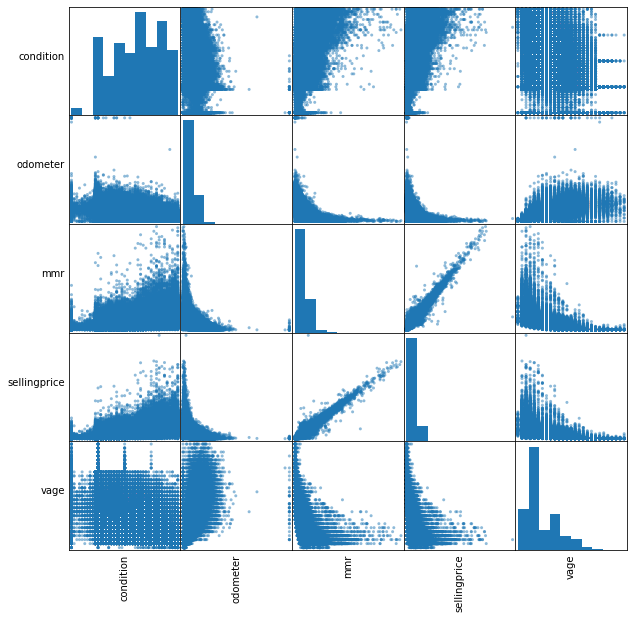

In [0]:
import pandas as pd
numeric_features = [t[0] for t in dfreal.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = dfreal.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [0]:
#Determine feature correlation of numeric columns
import six
for i in dfreal.columns:
    if not( isinstance(dfreal.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to sellingprice for ", i, dfreal.stat.corr('sellingprice',i))

Correlation to sellingprice for  condition 0.5359901118534298
Correlation to sellingprice for  odometer -0.5773849819198607
Correlation to sellingprice for  mmr 0.9834919120611123
Correlation to sellingprice for  sellingprice 1.0
Correlation to sellingprice for  vage -0.5772324944918457


### Building the Linear Regression model

In [0]:
# Import the required libraries

from pyspark.ml.regression import LinearRegression  #Note regression after pyspark.ml
from pyspark.ml.feature import VectorAssembler,StringIndexer,StandardScaler,OneHotEncoder
#from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [0]:
stages = []
for categoricalCol in categorical_columns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index',handleInvalid='keep')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

continous_columns = ['vage', 'condition', 'odometer', 'mmr']

assemblerInputs = [c + "classVec" for c in categorical_columns] + continous_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [0]:
stages

Out[110]: [StringIndexer_af383600cb9f,
 OneHotEncoder_d9a9feb6fce9,
 StringIndexer_f4f214abb5f3,
 OneHotEncoder_6bb687ab8711,
 StringIndexer_dda3de02a21f,
 OneHotEncoder_563bd10fbe99,
 StringIndexer_763ae3f63ac1,
 OneHotEncoder_2b521440463c,
 StringIndexer_3acc52631a38,
 OneHotEncoder_90cee4e176a0,
 StringIndexer_dac1be86b87c,
 OneHotEncoder_69059a45d283,
 StringIndexer_3f1e4a145a6e,
 OneHotEncoder_23ed52134245,
 StringIndexer_f60a30cd7045,
 OneHotEncoder_0d4e60c5fa2f,
 VectorAssembler_ae0eee8976c5]

In [0]:
# Create an object for the Linear Regression model
# The next step is to define the model training stage of the pipeline. 
# The following command defines a LinearRegression model that takes an input column "features" by default and learns to predict the labels in the "sellingprice" column.

lr_model = LinearRegression(labelCol='sellingprice')

In [0]:
# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data.

stages += [lr_model]
pipe = Pipeline(stages=stages)

In [0]:
# The total duration to train the model was around 3 minutes

fit_model=pipe.fit(train_data)

In [0]:
trainSummary = fit_model.stages[-1].summary
print("RMSE: %f" % trainSummary.rootMeanSquaredError)
print("\nr2: %f" % trainSummary.r2)

#print("Coefficients: " + str(fit_model.stages[-1].coefficients))
print("\nIntercept: " + str(fit_model.stages[-1].intercept))



RMSE: 1538.679901

r2: 0.974360

Intercept: -3269.386296785156


In [0]:
# Store the results in a dataframe

results = fit_model.transform(test_data)
display(results)

make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,vage,makeIndex,makeclassVec,modelIndex,modelclassVec,trimIndex,trimclassVec,bodyIndex,bodyclassVec,transmissionIndex,transmissionclassVec,stateIndex,stateclassVec,colorIndex,colorclassVec,interiorIndex,interiorclassVec,features,prediction
Acura,MDX,Base,SUV,automatic,ca,3.4,135515,black,beige,9800,11700,7,20.0,"Map(vectorType -> sparse, length -> 52, indices -> List(20), values -> List(1.0))",92.0,"Map(vectorType -> sparse, length -> 758, indices -> List(92), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1463, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 85, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 34, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 20, indices -> List(0), values -> List(1.0))",2.0,"Map(vectorType -> sparse, length -> 17, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 2435, indices -> List(20, 144, 810, 2274, 2358, 2361, 2394, 2416, 2431, 2432, 2433, 2434), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.0, 3.4, 135515.0, 9800.0))",10524.62031214016
Acura,MDX,Base,SUV,automatic,ca,3.6,34643,gray,black,26600,27000,2,20.0,"Map(vectorType -> sparse, length -> 52, indices -> List(20), values -> List(1.0))",92.0,"Map(vectorType -> sparse, length -> 758, indices -> List(92), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1463, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 85, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 34, indices -> List(1), values -> List(1.0))",3.0,"Map(vectorType -> sparse, length -> 20, indices -> List(3), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 17, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 2435, indices -> List(20, 144, 810, 2274, 2358, 2361, 2397, 2414, 2431, 2432, 2433, 2434), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.6, 34643.0, 26600.0))",26144.94729075176
Acura,MDX,Base,SUV,automatic,ca,3.8,40970,gray,black,25700,26000,2,20.0,"Map(vectorType -> sparse, length -> 52, indices -> List(20), values -> List(1.0))",92.0,"Map(vectorType -> sparse, length -> 758, indices -> List(92), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1463, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 85, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 34, indices -> List(1), values -> List(1.0))",3.0,"Map(vectorType -> sparse, length -> 20, indices -> List(3), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 17, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 2435, indices -> List(20, 144, 810, 2274, 2358, 2361, 2397, 2414, 2431, 2432, 2433, 2434), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.8, 40970.0, 25700.0))",25502.32783566744
Acura,MDX,Base,SUV,automatic,co,3.6,58105,blue,gray,24300,25000,3,20.0,"Map(vectorType -> sparse, length -> 52, indices -> List(20), values -> List(1.0))",92.0,"Map(vectorType -> sparse, length -> 758, indices -> List(92), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1463, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 85, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",19.0,"Map(vectorType -> sparse, length -> 34, indices -> List(19), values -> List(1.0))",4.0,"Map(vectorType -> sparse, length -> 20, indices -> List(4), values -

In [0]:
from  pyspark.sql.functions import abs
#predictions = linear_model.transform(test)
x =((results['sellingprice']-results['prediction'])/results['sellingprice'])*100
results = results.withColumn('Accuracy',100-abs(x))
results.select("prediction","sellingprice","Accuracy","features").show()

+------------------+------------+-----------------+--------------------+
|        prediction|sellingprice|         Accuracy|            features|
+------------------+------------+-----------------+--------------------+
| 10524.62031214016|       11700|89.95401976188171|(2435,[20,144,810...|
| 26144.94729075176|       27000| 96.8331381138954|(2435,[20,144,810...|
| 25502.32783566744|       26000|98.08587629102861|(2435,[20,144,810...|
|23958.304799638136|       25000|95.83321919855254|(2435,[20,144,810...|
|  4329.57430187114|        4500|96.21276226380311|(2435,[20,144,810...|
|18845.092645776796|       17100| 89.7947798492585|(2435,[20,144,810...|
|20569.691013399795|       20000|97.15154493300102|(2435,[20,144,810...|
| 4153.751795108383|        3100|  66.008006609407|(2435,[20,144,821...|
|3409.5517447836096|        3400|99.71906632989383|(2435,[20,144,821...|
|10490.633287531535|       11800|88.90367192823335|(2435,[20,293,810...|
| 9922.149993419533|        8000|75.97312508225585|

In [0]:
#results.show()
results.select(['sellingprice','prediction']).show()

+------------+------------------+
|sellingprice|        prediction|
+------------+------------------+
|       11700| 10524.62031214016|
|       27000| 26144.94729075176|
|       26000| 25502.32783566744|
|       25000|23958.304799638136|
|        4500|  4329.57430187114|
|       17100|18845.092645776796|
|       20000|20569.691013399795|
|        3100| 4153.751795108383|
|        3400|3409.5517447836096|
|       11800|10490.633287531535|
|        8000| 9922.149993419533|
|        4500|  6192.45796776164|
|        3700| 4940.103239171409|
|        5100|6364.1370541899905|
|        1300| 2112.127852411843|
|        1600| 1422.905075026823|
|        3900|3715.4925084893316|
|        6800| 5969.605440988869|
|        2800|2547.4628026219802|
|        6500| 6849.544229471099|
+------------+------------------+
only showing top 20 rows



### Evaluating the model

In [0]:
#And evaluate how well is our model doing. Our metrics will be RMSE, MSE, MAE and R^2.

from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(results)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(results, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(results, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(results, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 1534.841
MSE: 2355738.182
MAE: 961.366
r2: 0.975


In [0]:
eval.explainParams()

Out[119]: 'labelCol: label column name. (default: label, current: sellingprice)\nmetricName: metric name in evaluation - one of:\n                       rmse - root mean squared error (default)\n                       mse - mean squared error\n                       r2 - r^2 metric\n                       mae - mean absolute error\n                       var - explained variance. (default: rmse, current: rmse)\npredictionCol: prediction column name. (default: prediction, current: prediction)\nthroughOrigin: whether the regression is through the origin. (default: False)\nweightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)'

In other words, the relationship between sellingprice and features accounts for 97.5% of the variation. Said yet another way, selected features are a good predictor of selligprice because when the features go up so does the sellingprice and vice versa.